In [1]:
# 导入matplotlib库
import matplotlib.pyplot as plt
 
# 设置默认绘图风格
plt.style.use("seaborn")  

In [2]:
import lightgbm as lgb
from keras.models import load_model
import os
import warnings
warnings.filterwarnings("ignore")

filepath = './'

#扫描当前文件夹下所有文件名
file_name_list = os.listdir(filepath)

Using TensorFlow backend.


In [3]:
lgb_list = []
lstm_list = []

for each_filename in file_name_list:
    #print(each_filename)
    if 'lc_lgb' in each_filename:
        #print(each_filename)
        lgb_list.append(lgb.Booster(model_file=each_filename))
    elif 'lc_lstm' in each_filename:
        #print(each_filename)
        lstm_list.append(load_model(each_filename))

In [4]:
import mytool#导入自用工具

import sklearn
import pandas as pd
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences#序列长度统一化要用到的工具
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.utils import to_categorical
import lightgbm as lgb
from collections import Counter

path = r'cv_data.txt'
stopword_path = r'stopwords.txt'

data = pd.read_csv(path,engine='python',encoding='utf-8')
data = data.drop(columns=['game_id','user_id','issue_time','user_score','phone_type'])#删除不必要的列

#导入停用词表
stopwords = []

with open(stopword_path,'r',encoding="utf-8") as f:
    for line in f.readlines():
        line = line.strip('\n')#readlines会读入\n先去掉
        stopwords.append(line)

In [5]:
temp_X_train, temp_X_test, temp_y_train, temp_y_test = train_test_split(data[[col for col in data.columns if col != 'label']], data['label'], 
                                                    test_size=10000, 
                                                    random_state=0)

#记录索引
test_id = temp_y_test.index
train_id = temp_y_train.index

In [6]:
#训练集、验证集所用数据
train_data = data.iloc[train_id,:]
train_id_list, val_id_list = mytool.k_s_fold(train_data,10)#作十折

In [7]:
#gbdt部分数据处理
tf_idf = mytool.tf_idf_method(data,stopwords)
tf_idf.tf_idf_vec()#tf_idf化
X = tf_idf.final_X
y = data['label']
X_name_list = tf_idf.feature_name

In [8]:
#单独取出lgb测试集
lgb_test_y = y[test_id]
lgb_test_X = X[test_id,:]

In [9]:
#lgb在测试集上的表现
lgb_acc = []
lgb_precision = []
lgb_recall = []
lgb_f1 = []

for each_lgb_model in lgb_list:
    pred_y = (each_lgb_model.predict(lgb_test_X)>0.5)
    
    lgb_acc.append(metrics.accuracy_score(lgb_test_y,pred_y))
    lgb_precision.append(metrics.precision_score(lgb_test_y,pred_y))
    lgb_recall.append(metrics.recall_score(lgb_test_y,pred_y))
    lgb_f1.append(metrics.f1_score(lgb_test_y,pred_y))

In [10]:
#lstm部分数据处理
new_data, dic_id2word, dic_word2id = mytool.idlize(data)#构建本数据的词典

max_len = int(new_data['word_num'].quantile(q=0.90))#输入维度，评论词数的0.90分位数

word_X = mytool.pad_same_dim_X(max_len, new_data)
y = new_data['label']

In [11]:
#单独取出lstm测试集
lstm_test_y = y[test_id]
lstm_test_X = word_X[test_id,:]

In [12]:
#lstm在测试集上的表现
lstm_acc = []
lstm_precision = []
lstm_recall = []
lstm_f1 = []

for each_lstm_model in lstm_list:
    pred_y = each_lstm_model.predict_classes(lstm_test_X)
    
    lstm_acc.append(metrics.accuracy_score(lstm_test_y,pred_y))
    lstm_precision.append(metrics.precision_score(lstm_test_y,pred_y))
    lstm_recall.append(metrics.recall_score(lstm_test_y,pred_y))
    lstm_f1.append(metrics.f1_score(lstm_test_y,pred_y))

In [13]:
#在训练集上的表现
lstm_train_acc = []
lstm_train_precision = []
lstm_train_recall = []
lstm_train_f1 = []

lgb_train_acc = []
lgb_train_precision = []
lgb_train_recall = []
lgb_train_f1 = []

In [14]:
index_accum = []#采用累积形式增长数据量，记录index
for each_val_id_list,each_lgb_model,each_lstm_model in zip(val_id_list,lgb_list,lstm_list):
    index_accum += (each_val_id_list.tolist())
    
    use_y = y[index_accum]
    use_lgb_X = X[index_accum,:]
    use_lstm_X = word_X[index_accum,:]
    
    lgb_pred_y = (each_lgb_model.predict(use_lgb_X)>0.5)
    lstm_pred_y = each_lstm_model.predict_classes(use_lstm_X)

    #lgb
    lgb_train_acc.append(metrics.accuracy_score(use_y,lgb_pred_y))
    lgb_train_precision.append(metrics.precision_score(use_y,lgb_pred_y))
    lgb_train_recall.append(metrics.recall_score(use_y,lgb_pred_y))
    lgb_train_f1.append(metrics.f1_score(use_y,lgb_pred_y))
    
    #lstm
    lstm_train_acc.append(metrics.accuracy_score(use_y,lstm_pred_y))
    lstm_train_precision.append(metrics.precision_score(use_y,lstm_pred_y))
    lstm_train_recall.append(metrics.recall_score(use_y,lstm_pred_y))
    lstm_train_f1.append(metrics.f1_score(use_y,lstm_pred_y))

In [15]:
def plot_metrics(AX, lgb_XX, lstm_XX, lgb_train_XX, lstm_train_XX, title, X, X_label):
    '''
        对每个metric进行作画比较
        输入:
            AX:对应画布空间
            lgb_XX:lgb模型验证集数据
            lstm_XX:lstm模型验证集数据
            lgb_train_XX:lgb模型训练集数据
            lstm_train_XX:lstm模型训练集数据
            title:所画metric的名称
            X:x轴各值
            X_label：x轴各标度名称
        输出：
            AX:完成绘画的新画布
    '''
    #图标题部分
    AX.set_title(title,fontsize=8)
    #AX.title.set_text(title,fontsize=8)
    #x轴部分
    AX.set_xticks(X)
    AX.set_xticklabels(X_label,{'fontsize':6})
    AX.set_xlabel('Train Size',fontsize=7)
    #y轴部分
    AX.set_yticks([0.7,0.75,0.8,0.85,0.9,0.95,1])
    AX.set_yticklabels(['0.7','0.75','0.8','0.85','0.9','0.95','1'],{'fontsize':6})#字体设置
     #标签旋转
    for tick in AX.get_xticklabels():
        tick.set_rotation(-45)
    
    
    #lgb部分
    AX.plot(X,lgb_XX,color='green',marker='o',markersize=2,linewidth=1,label='lgb_val')
    AX.plot(X,lgb_train_XX,color='green',marker='o',linestyle='--',markersize=2,linewidth=1,label='lgb_train')
    
    #lstm部分
    AX.plot(X,lstm_XX,color='blue',marker='o',markersize=2,linewidth=1,label='lstm_val')
    AX.plot(X,lstm_train_XX,color='blue',marker='o',linestyle='--',markersize=2,linewidth=1,label='lstm_train')
    
    
    
    return AX

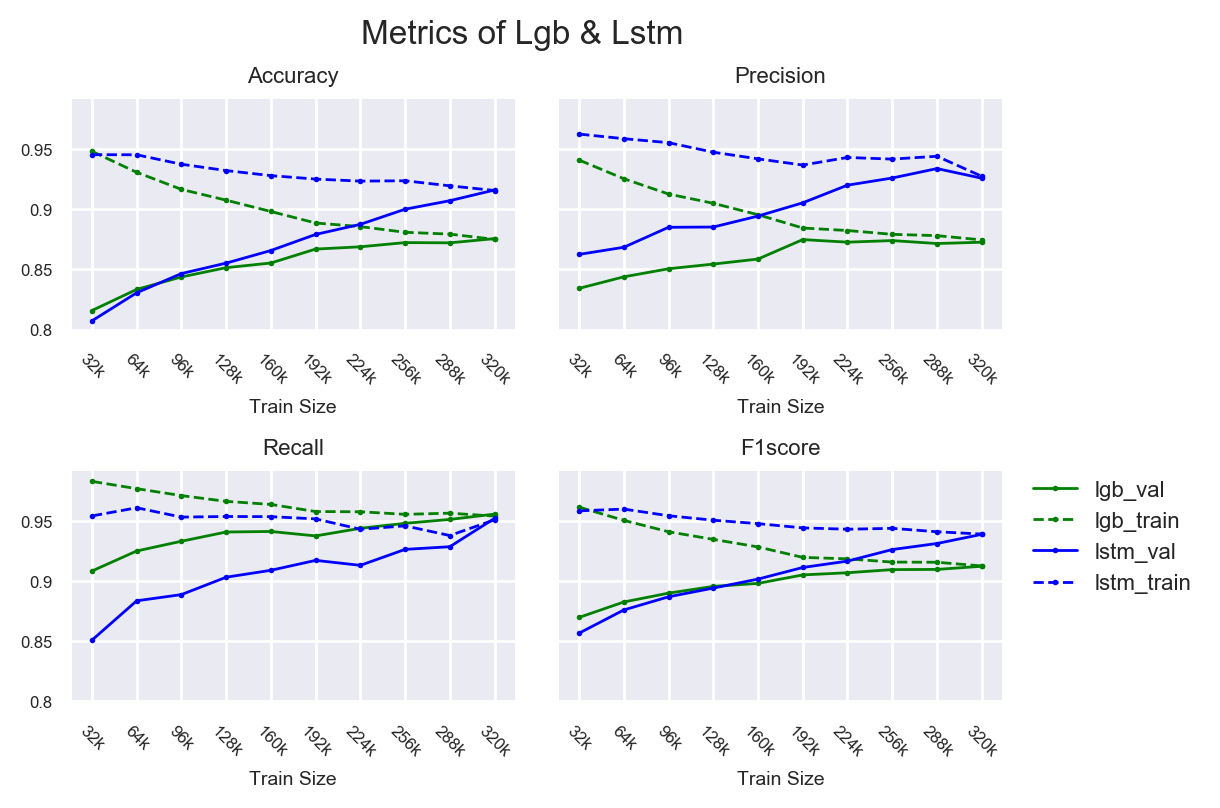

In [16]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, dpi=200) 
# fig = plt.figure(dpi=200,sharex=True)
# ax1 = fig.add_subplot(2,2,1)
# ax2 = fig.add_subplot(2,2,2)
# ax3 = fig.add_subplot(2,2,3)
# ax4 = fig.add_subplot(2,2,4)

fig.subplots_adjust(hspace = 0.6,wspace=0.1)#left=None, bottom=None, right=None, top=None,wspace=None, hspace=None

# fig, axes = plt.subplots(2, 2, sharey=True, dpi=200)

X = [i+1 for i in range(len(lstm_acc))]

X_label = [(str(i*32)+'k') for i in X]

ax1 = plot_metrics(ax1,lgb_acc,lstm_acc,lgb_train_acc,lstm_train_acc,'Accuracy',X,X_label)
ax2 = plot_metrics(ax2,lgb_precision,lstm_precision,lgb_train_precision,lstm_train_precision,'Precision',X,X_label)
ax3 = plot_metrics(ax3,lgb_recall,lstm_recall,lgb_train_recall,lstm_train_recall,'Recall',X,X_label)
ax4 = plot_metrics(ax4,lgb_f1,lstm_f1,lgb_train_f1,lstm_train_f1,'F1score',X,X_label)


ax4.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.,fontsize=8)     ##设置ax4中legend的位置，将其放在图外

plt.suptitle('Metrics of Lgb & Lstm')#总标题

plt.show()